# QUORA - DUPLICATE QUESTION IDENTIFICATION

Quora is visited by more than 95 million visitors each month, so its natural that there are many duplicate questions or questions with similar intent. Due to multiple similar questions visitors have to spend a lot of time to find better answers and also writers have to spend time to answer question with same intent multiple times. The aim of this project is to predict pairs of questions that have similar meaning. In order to solve this problem, natural language processing techniques will be used like TF-IDF, word embeddings and then a
classifier algorithm like XGBoost will be used to classify if question pairs are duplicates or not

In [1]:
import numpy as np
import pandas as pd
import gensim as gn
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.word2vec import Word2Vec
import nltk
from nltk.data import load
#graph polotting library
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine,euclidean
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### LOAD TRAINING AND TEST DATA

In [2]:
data = pd.read_csv('train.csv')

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.3)

### SAMPLE TRAINING DATA

In [5]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
119853,119853,194501,194502,What is brand awareness?,What is the brand awareness of Samsung?,0
68011,68011,117606,117607,What is the best therapy for dyshidrotic eczema?,Who is the best therapy for eczema?,0
240565,240565,184918,69841,Which intersections in Philadelphia are partic...,Which intersections in Minneapolis are particu...,0
330639,330639,390859,155543,Why is the Indian government not releasing pro...,Why is the Indian army not releasing any pictu...,1
206560,206560,310015,145591,What are the best books to learn algorithm?,What are the best books to learn algorithms in...,0


### SAMPLE TEST DATA

In [6]:
df_test.head()

,id,qid1,qid2,question1,question2,is_duplicate
240675,240675,67073,62194,What is 45minuteswealth.com?,What is osell.com?,0
132722,132722,212463,212464,Which full stack developer are you?,Am I a full stack developer?,0
311588,311588,46038,59296,How do I start my own TV channel in the US?,How can I start internet TV channel?,1
396511,396511,529575,529576,How can you find the magnitude of an electric ...,How can the magnitude of an electric field be ...,1
213277,213277,318559,318560,What are the top five responsibilities of a ma...,Have you ever fallen in love with an unattract...,0


#### TOTAL NUMBER OF RECORDS IN TRAINING DATA, TEST DATA AND % OF DUPLICATE PAIRS IN TRAINING DATA

In [7]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for test data: {}'.format(len(df_test)))
print('Duplicate pairs : {} %'.format(round(df_train['is_duplicate'].mean()*100,2)))
df_train.is_duplicate.value_counts()

Total number of question pairs for training: 2000
Total number of question pairs for test data: 2000
Duplicate pairs : 38.15 %


0    1237
1     763
Name: is_duplicate, dtype: int64

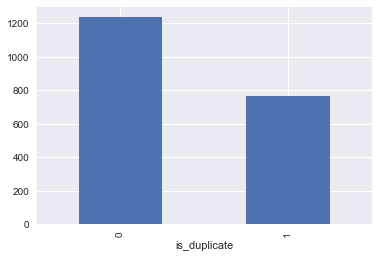

In [8]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

### DISTRIBUTION OF WORD COUNT IN TRAINING AND TEST DATA

In [10]:
train = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
dist_train = train.apply(lambda x: len(x.split(' ')))
dist_test = test.apply(lambda x: len(x.split(' ')))

In [11]:
# train is a pandas series object. Displaying first 2 elements of train series 
train[0:2]

0                            What is brand awareness?
1    What is the best therapy for dyshidrotic eczema?
dtype: object

In [12]:
# dist_train is a pandas series object. Displaying length of first 2 elements of train series 
dist_train[0:2]

0    4
1    8
dtype: int64

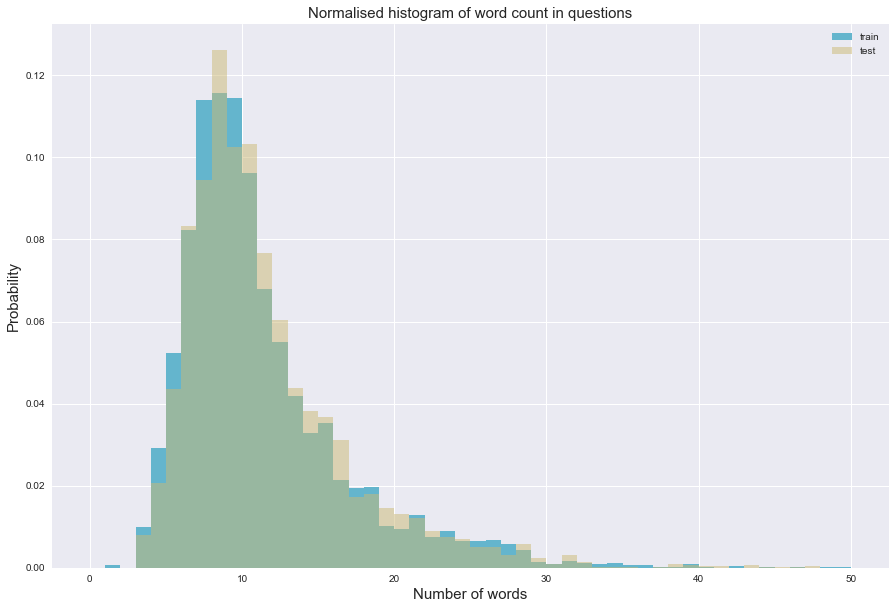

In [13]:
col = sns.color_palette()
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color= col[5], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color= col[4], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### WORDCLOUD PLOT USING WORDCLOUD LIBRARY IN TRAINING DATAFRAME

(-0.5, 1439.5, 1079.5, -0.5)

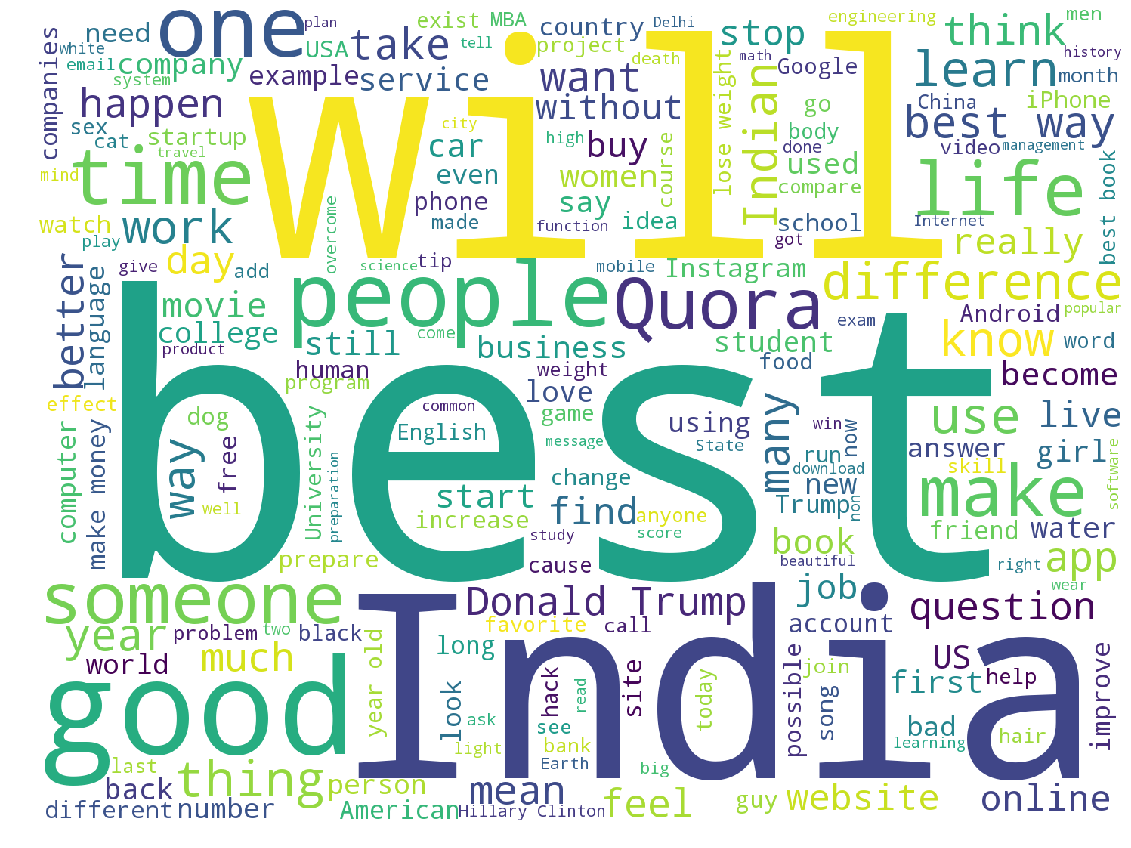

In [14]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080,background_color='white').generate(" ".join(train.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### TF-IDF (term-frequency-inverse-document-frequency)

In [15]:
from collections import Counter
import scipy.sparse as sparse
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1.0 / (count + eps)

eps = 5000
words = (" ".join(train)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [16]:
first2pairs = {k: weights[k] for k in weights.keys()[:20]}

In [17]:
print first2pairs

{'basics': 9.998000399920016e-05, 'looking': 9.99000999000999e-05, 'hormone': 9.998000399920016e-05, 'prize': 0, 'eligible': 0, 'electricity': 9.998000399920016e-05, 'bringing': 0, 'ocean?': 9.998000399920016e-05, 'writing?': 9.998000399920016e-05, 'four': 9.998000399920016e-05, 'wooden': 0, 'hostel?': 0, 'inward?': 0, 'advice:': 0, 'lord': 0, 'wood?': 0, 'downloads?': 0, 'lumia': 9.998000399920016e-05, 'judicial': 0, 'tatkal': 9.996001599360256e-05}


#### Most common words and weights

In [18]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0.0 else 9999)[:10])

Most common words and weights: 

[('the', 8.445232666159953e-05), ('what', 8.602890571231934e-05), ('is', 8.797395970792646e-05), ('how', 9.026085386767759e-05), ('i', 9.03750564844103e-05), ('a', 9.089256498818396e-05), ('to', 9.100837277029486e-05), ('in', 9.165902841429881e-05), ('do', 9.25240562546262e-05), ('of', 9.255831173639393e-05)]


#### Least common words and weights

In [19]:
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

[('ocean?', 9.998000399920016e-05),
 ('four', 9.998000399920016e-05),
 ('electricity', 9.998000399920016e-05),
 ('hormone', 9.998000399920016e-05),
 ('writing?', 9.998000399920016e-05),
 ('lumia', 9.998000399920016e-05),
 ('basics', 9.998000399920016e-05),
 ('path', 9.998000399920016e-05),
 ('her?', 9.998000399920016e-05),
 ('fossil', 9.998000399920016e-05)]

### FEATURE GENERATION - WRITING A FUNCTION (generate_features) to add new columns to df_train

In [20]:
def generate_features(df_train):
    #Number of characters (including spaces) in Question
    df_train['len_q1'] = df_train['question1'].apply(lambda x:len(str(x)))
    df_train['len_q2'] = df_train['question2'].apply(lambda x:len(str(x)))
    
    #Difference in number of characters in q1 and q2
    df_train['diff_len'] = df_train.len_q1-df_train.len_q2
    
    #Number of unique (used 'set' for finding unique) characters in question
    df_train['len_char_q1'] = df_train.question1.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_char_q2'] = df_train.question2.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    
    # Number of words in question
    df_train['len_word_q1'] = df_train.question1.apply(lambda x:len(str(x).split()))
    df_train['len_word_q2'] = df_train.question2.apply(lambda x:len(str(x).split()))
    
    #Number of common words in question
    df_train['common_words'] = df_train.apply(lambda x:len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))),axis=1)
    return df_train

In [21]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
119853,119853,194501,194502,What is brand awareness?,What is the brand awareness of Samsung?,0,24,39,-15,13,19,4,7,3
68011,68011,117606,117607,What is the best therapy for dyshidrotic eczema?,Who is the best therapy for eczema?,0,48,35,13,18,17,8,7,6
240565,240565,184918,69841,Which intersections in Philadelphia are partic...,Which intersections in Minneapolis are particu...,0,104,103,1,22,22,15,15,14


In [22]:
df_train.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'len_word_q1', u'len_word_q2', u'common_words'],
      dtype='object')

In [23]:
df_train.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'len_q1', u'len_q2', u'diff_len', u'len_char_q1', u'len_char_q2',
       u'len_word_q1', u'len_word_q2', u'common_words'],
      dtype='object')

### CREATING LDA (Lattent Dirichlet Allocation) features - DOING CLUSTERING ON CORPUS TO GET COMMON TOPICS

In [24]:
# Stemming
import re
p_stemmer = PorterStemmer()
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

# Function to build a corpus
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [25]:
data = clean_dataframe(df_train)
corpus = build_corpus(data)
dictionary = corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in corpus]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary)

In [26]:
def common_lda_topic(sentence1,sentence2,dictionary,ldamodel,min_proba):
    "find #common topic based on lattent dirichlet allocation model"
    sentence1 = sentence1.split()
    sentence2 = sentence2.split()

    sentence1 = dictionary.doc2bow(sentence1)
    sentence2 = dictionary.doc2bow(sentence2)
    
    topic_a = ldamodel.get_document_topics(sentence1,minimum_probability=min_proba)
    topic_b = ldamodel.get_document_topics(sentence2,minimum_probability=min_proba)
    
    topic_a = list(sorted(topic_a, key=lambda x: x[1]))
    topic_b = list(sorted(topic_b, key=lambda x: x[1]))
    common_topic = set([x[0] for x in topic_a]).intersection(x[0] for x in topic_b)
    return(len(common_topic))

#### ADDING NEW COLUMN 'COMMON_TOPICS' FROM TOPICS GENERATED IN PREVIOUS STEP

In [27]:
df_train['common_topics'] = df_train.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)
df_test['common_topics'] = df_test.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)

In [28]:
df_train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,common_topics
119853,119853,194501,194502,What is brand awareness?,What is the brand awareness of Samsung?,0,24,39,-15,13,19,4,7,3,0
68011,68011,117606,117607,What is the best therapy for dyshidrotic eczema?,Who is the best therapy for eczema?,0,48,35,13,18,17,8,7,6,1


### CREATING POS-TAGGING FEATURES

In [29]:
def common_pos_tagging(question1,question2):
    question1 = nltk.word_tokenize(question1)
    question2 = nltk.word_tokenize(question2)
    pos_question1 = nltk.pos_tag(question1)
    pos_question2 = nltk.pos_tag(question2)

    pos_1_array = [x[1] for x in pos_question1]
    pos_2_array = [x[1] for x in pos_question2]
    return(len(set(pos_1_array).intersection(pos_2_array)))

In [30]:
def count_distinct_pos_tagging(df_train):
    #Generate all pos-tag null columns
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    pos_tag = tagdict.keys()
    for tag in pos_tag:
        df_train[tag+"_q1"] = 0
        df_train[tag+"_q2"] = 0
        
    for index, row in df_train.iterrows():
        question1 = row.question1.decode('utf-8')
        question1 = nltk.word_tokenize(question1)

        question2 = row.question2.decode('utf-8')
        question2 = nltk.word_tokenize(question2)

        pos_question1 = nltk.pos_tag(question1)
        pos_question1 = [x[1] for x in pos_question1]

        pos_question2 = nltk.pos_tag(question2)
        pos_question2 = [x[1] for x in pos_question2]

        for tag in pos_question1:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q1",row[tag+"_q1"]+1)

        for tag in pos_question2:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q2",row[tag+"_q2"]+1)

In [31]:
df_train['common_pos_count'] = df_train.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
df_test['common_pos_count'] = df_test.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
count_distinct_pos_tagging(df_train)
count_distinct_pos_tagging(df_test)

In [36]:
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,...,--_q1,--_q2,JJS_q1,JJS_q2,JJR_q1,JJR_q2,SYM_q1,SYM_q2,UH_q1,UH_q2
278160,278160,81565,42867,What are the best resources to learn Javascript?,What is the easiest way to learn JavaScript?,1,48,44,4,18,...,0,0,1,1,0,0,0,0,0,0
232043,232043,277785,341985,Which is the best foreign (non-US) film of the...,What are some good foreign films released in 2...,0,57,50,7,27,...,0,0,1,0,0,0,0,0,0,0
189237,189237,287952,287953,Why is Noida becoming so inferior in compariso...,Can I appear for KVPY exam if I am in class 11...,0,68,57,11,23,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_train.shape

(2000, 106)

# Word2vec features 
Word2Vec creates a multi-dimensional vector for every word in the english vocabulary (or the corpus it has been trained on). Word2Vec embeddings are very popular in natural language processing and always provide us with great insights. Wikipedia provides a good explanation of what these embeddings are and how they are generated (https://en.wikipedia.org/wiki/Word2vec).

In [33]:
import gensim

In [34]:
#model = gn.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
model.init_sims(replace=True)

In [35]:
print("Word2vec mean of president : {} mean of obama {}".format(model['money'].mean(),model['return'].mean()))

Word2vec mean of president : -0.0012649782002 mean of obama 0.00183828349691


The idea here is to build a vector of each word in differents sentences (question1, question2), each word will be presented in a 300 dimensions vector. So we will try to calculate the average of these vector in order to compare the result obtained in the first and second question. I will calculate differents distances based on theses vectors such as euclidiant distance, cosine similiratity and generate some features based on semantic of words. So, if sentence $s1$ contains $K$ words, we can present this sentence by $K$ arrays of $300$ dimensions. So a matrix of $[K*300]$.

An example of the application of this model is to find the word the most similar to a particular word (semantic sense I mean). Lets try to find the most similar word to `Obama`.

In [36]:
model.most_similar(positive=["returns"])

[(u'return', 0.6663143634796143),
 (u'Returns', 0.5789523124694824),
 (u'returning', 0.5019497871398926),
 (u'returned', 0.46012505888938904),
 (u'Return', 0.45124897360801697),
 (u'recovers', 0.42995738983154297),
 (u'arrives', 0.4253024458885193),
 (u'departs', 0.40843576192855835),
 (u'reclaims', 0.4020119905471802),
 (u'Returning', 0.3935914933681488)]

In [37]:
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = nltk.word_tokenize(words)
    words = [w for w in words if not w in STOP_WORDS]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    return M

In [38]:
df_train.iloc[0].question1

'What is brand awareness?'

We will take now an example of a sentence and apply the word2vec model of words that contains, Lets take the first observation of the train dataframe. It's `'What is the step by step guide to invest in share market in india?'`, so this sentences contains 7 words (after deleting stop words). So this sentence will be presented by a $[7*300]$ matrix. Let's do that

In [106]:
m = sent2vec(df_train.iloc[0].question1)
#print("The sentences vectors {}, the shape of this vector is : {}".format(m,m.shape))

The disadvantage of the `word2vec` model that we can't present all the sentence but only words, so we will try some metodologies to present all the sentence using the `word2vec` model, we will for example try to sum the `word2vec` array and calculate the distance between the 2 questions. So each question will be presented using a ${R}^{300}$ vector, and calculate the distance between two ${R}^{300}$ vectors

In [40]:
model.most_similar(positive=["RRSP"])

[(u'RRSPs', 0.8417857885360718),
 (u'TFSA', 0.8104437589645386),
 (u'RRSP_contribution', 0.7463574409484863),
 (u'TFSAs', 0.7375255227088928),
 (u'RRSP_contributions', 0.7317193746566772),
 (u'Roth_IRA', 0.6847102642059326),
 (u'RESP', 0.6815884113311768),
 (u'RESPs', 0.6733701229095459),
 (u'RRIF', 0.6640373468399048),
 (u'Roth_IRAs', 0.6563006639480591)]

### Calculcate differents distances (euclidian, cosine)
We will try now to calculate the distance between two questions. i.e between the two ${R}^{300}$ vector, so we will present these two vector as 2 points in a plan of $300$ dimensions, and calculate the distance between those points. Let's do that

In [41]:
def word2vec_sentences(s):
    M = sent2vec(s)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [42]:
from tqdm import tqdm
# Array contains the word2vec sum (sentences)
question1_vectors = np.zeros((df_train.shape[0], 300))
question2_vectors = np.zeros((df_train.shape[0], 300))

question1_test_vectors = np.zeros((df_test.shape[0], 300))
question2_test_vectors = np.zeros((df_test.shape[0], 300))
for i, q in tqdm(enumerate(df_train.question1.values)):
    question1_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_train.question2.values)):
    question2_vectors[i, :] = word2vec_sentences(q)
    
for i, q in tqdm(enumerate(df_test.question1.values)):
    question1_test_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_test.question2.values)):
    question2_test_vectors[i, :] = word2vec_sentences(q)

2000it [00:01, 1562.20it/s]
2000it [00:01, 1600.18it/s]
2000it [00:01, 1581.91it/s]
2000it [00:01, 1542.37it/s]


In [43]:
df_train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_train['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]

df_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]
df_test['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]



In [44]:
df_train.euclidean_distance.describe()

count    2000.000000
mean        0.675614
std         0.309389
min         0.000000
25%         0.505545
50%         0.690296
75%         0.868386
max         1.400539
Name: euclidean_distance, dtype: float64

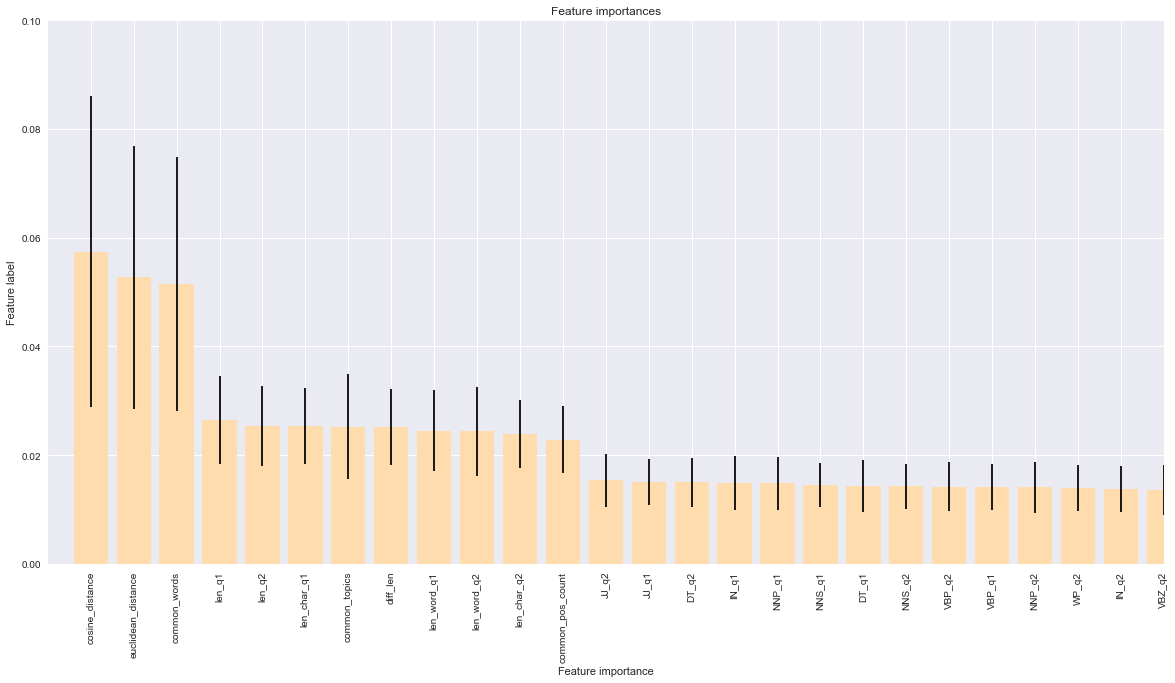

In [46]:
# Build a forest and compute the feature importances
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
train = df_train.ix[:, 6:,]
train = train.fillna(0)
forest.fit(train, df_train.is_duplicate)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
list = train.columns.values
# Print the feature ranking
#print("Feature ranking:")

#for f in range(train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],color='#ffdcad', yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), list[indices],rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0,.1])
plt.xlabel("Feature importance")
plt.ylabel("Feature label")
plt.show()

In [49]:
df_test1=df_test.drop('is_duplicate',axis=1)
df_test2=df_test1.drop(['qid1','qid2'],axis=1)

### Logistic Regression

In [52]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
X = df_train.ix[:, 6:,]
X = X.fillna(0)
Y = df_train.is_duplicate
print('Train shape : {}, Test shape : {}'.format(X.shape,df_test2.ix[:, 3:,].shape))
logreg.fit(X, Y)
df_test2 = df_test2.fillna(0)
proba_replicated = logreg.predict_proba(df_test2.ix[:, 3:,])
proba = proba_replicated[:,1]
len(proba)
sub = pd.DataFrame()
sub['id'] = df_test2['id']
sub['is_duplicate'] = proba
sub.to_csv('simple_lr.csv', index=False)

Train shape : (2000, 102), Test shape : (2000, 102)


In [64]:
predclass=logreg.predict(df_test2.ix[:, 3:,])

In [67]:
sub['pred_class'] = predclass

In [69]:
sub['actual_class']=df_test.is_duplicate

In [70]:
sub.head()

,test_id,is_duplicate,pred_class,actual_class
240675,240675,0.300832,0,0
132722,132722,0.415539,0,0
311588,311588,0.587771,1,1
396511,396511,0.579486,1,1
213277,213277,0.003054,0,0


In [71]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(sub.actual_class, sub.pred_class)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.7426529   0.57894737]
recall: [ 0.74979952  0.56972112]
fscore: [ 0.7462091   0.57429719]
support: [1247  753]


In [53]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(logreg, X, Y, cv=5, scoring='accuracy')
scores.mean()

0.7060210563816024

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(sub.actual_class, sub.pred_class)

array([[935, 312],
       [324, 429]])

## RANDOM FOREST

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [100]:
clf = RandomForestClassifier(n_estimators=100,max_depth=20, random_state=0)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [101]:
rf_pred_class=clf.predict(df_test2.ix[:, 3:,])

In [102]:
sub['rf_pred_class'] = rf_pred_class

In [103]:
sub.head()

,test_id,is_duplicate,pred_class,actual_class,rf_pred_class
240675,240675,0.300832,0,0,0
132722,132722,0.415539,0,0,1
311588,311588,0.587771,1,1,0
396511,396511,0.579486,1,1,1
213277,213277,0.003054,0,0,0


In [104]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(sub.actual_class, sub.rf_pred_class)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.75153374  0.61637931]
recall: [ 0.78588613  0.56972112]
fscore: [ 0.76832615  0.59213251]
support: [1247  753]


## CONFUSION MATRRIX

In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix(sub.actual_class, sub.rf_pred_class)

array([[980, 267],
       [324, 429]])

## XG BOOST

In [54]:
# Set our parameters for xgboost
from sklearn.metrics import accuracy_score
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
x_train = df_train.ix[:, 6:,]
y_train = df_train.is_duplicate
d_train = xgb.DMatrix(x_train, label=y_train)
bst = xgb.train(params, d_train, 400)
test = df_test2.ix[:, 3:,]
d_test = xgb.DMatrix(test)
p_test = bst.predict(d_test)
sub = pd.DataFrame()
sub['test_id'] = df_test['id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

In [55]:
preds = pd.read_csv("simple_xgb.csv")
preds.head()

,test_id,is_duplicate
0,240675,0.300832
1,132722,0.415539
2,311588,0.587771
3,396511,0.579486
4,213277,0.003054
